In [1]:
import pandas as pd
import xml.etree.ElementTree as xet
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import easyocr
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import InceptionResNetV2, EfficientNetB6, InceptionV3
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model
from sklearn.utils import validation
import tensorflow as tf
reader = easyocr.Reader(['en'])

c:\Users\ASUS\miniconda3\envs\gpu_access\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### A. Load Data

In [3]:
path = glob('D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/merge/*.xml')
path[:5]

['D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/merge\\K1_A4638EG.xml',
 'D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/merge\\K1_AA2125VK.xml',
 'D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/merge\\K1_AA2344SP.xml',
 'D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/merge\\K1_AA2412RJ.xml',
 'D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/merge\\K1_AA2503XT.xml']

In [4]:
labels_dict = dict(filepath=[], xmin=[], xmax=[], ymin=[], ymax=[])
for filename in path:
  info = xet.parse(filename)
  root = info.getroot()
  member_object = root.find('object')
  labels_info = member_object.find('bndbox')
  xmin = int(labels_info.find('xmin').text)
  xmax = int(labels_info.find('xmax').text)
  ymin = int(labels_info.find('ymin').text)
  ymax = int(labels_info.find('ymax').text)
  labels_dict['filepath'].append(filename)
  labels_dict['xmin'].append(xmin)
  labels_dict['xmax'].append(xmax)
  labels_dict['ymin'].append(ymin)
  labels_dict['ymax'].append(ymax)

In [5]:
df = pd.DataFrame(labels_dict)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/mer...,823,1869,1210,1542
1,D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/mer...,303,845,945,1082
2,D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/mer...,259,619,482,631
3,D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/mer...,632,1657,1627,1943
4,D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/mer...,716,1641,1410,1835


### B. Object Detection

In [6]:
df = pd.read_csv('labels.csv')
df.head()

,filepath,xmin,xmax,ymin,ymax
0,D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/mer...,900,1743,2051,2328
1,D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/mer...,1259,2034,2207,2463
2,D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/mer...,601,995,1565,1687
3,D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/mer...,721,1936,2133,2583
4,D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/mer...,1017,1839,1463,1707


In [7]:
filename = df['filepath'][0]
filename

'D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/merge\\K3-B2183TZL.xml'

In [8]:
def getFilename(filename):
  filename_image = xet.parse(filename).getroot().find('filename').text
  filepath_image = os.path.join('D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/merge', filename_image)
  return filepath_image

In [9]:
df['imagepath']= list(df['filepath'].apply(getFilename))
df[:5]

,filepath,xmin,xmax,ymin,ymax,imagepath
0,D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/mer...,900,1743,2051,2328,D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/mer...
1,D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/mer...,1259,2034,2207,2463,D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/mer...
2,D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/mer...,601,995,1565,1687,D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/mer...
3,D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/mer...,721,1936,2133,2583,D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/mer...
4,D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/mer...,1017,1839,1463,1707,D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/mer...


In [10]:
df.to_csv('data_new.csv', index=0)

#### B.1 Verify Image

In [11]:
file_path = df.iloc[1][-1]
x_min = df.iloc[1][1]
y_min = df.iloc[1][3]
x_max = df.iloc[1][2]
y_max = df.iloc[1][4]
file_path

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5512\1482977816.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  file_path = df.iloc[1][-1]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5512\1482977816.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_min = df.iloc[1][1]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5512\1482977816.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_min = df.iloc[1][3]
C:\Users\ASUS\AppData\Local\Temp

'D:/Kuliah/Semester 7/PAI/Deteksi Plat/Data/merge\\K3_A1460RA.jpg'

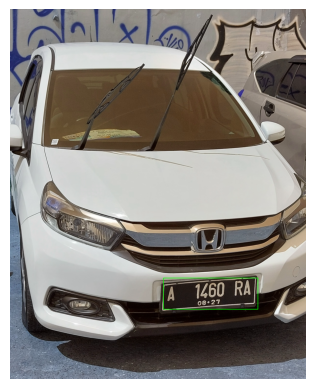

In [12]:
img = cv2.imread (file_path)
cv2.rectangle(img,(x_min, y_min), (x_max, y_max), (0,255,0),3)
plt.axis('off')
plt.imshow(img)

#### B.2 Data Preprocessing

In [ ]:
labels = df.iloc[:,1:5].values
labels

In [14]:
data = []
output = []
image_path = df['imagepath']
for ind in range(len(image_path)):
  image = image_path[ind]
  img_arr = cv2.imread(image)
  h,w,d, = img_arr.shape
  # preprocessing
  load_image = load_img(image, target_size=(224,224))
  load_image_arr = img_to_array(load_image)
  norm_load_image_arr = load_image_arr/255.0
  # normalization to labels
  xmin, xmax, ymin, ymax = labels[ind]
  nxmin, nxmax = xmin/w, xmax/w
  nymin, nymax = ymin/h, ymax/h
  label_norm = (nxmin, nxmax, nymin, nymax)
  data.append(norm_load_image_arr)
  output.append(label_norm)

In [15]:
X = np.array(data, dtype=np.float32)
y = np.array(output, dtype=np.float32)

X.shape, y.shape

((156, 224, 224, 3), (156, 4))

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((140, 224, 224, 3), (16, 224, 224, 3), (140, 4), (16, 4))

#### B.3 Modelling

In [70]:
inception_resnet = InceptionResNetV2(weights="imagenet", input_tensor=Input(shape=(224,224,3)))
inception_resnet.trainable = False
# ------------------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(250, activation='relu')(headmodel)
headmodel = Dense(100, activation='relu')(headmodel)
headmodel = Dense(50, activation='relu')(headmodel)
headmodel = Dense(4, activation='sigmoid')(headmodel)

model = Model(inputs=inception_resnet.input, outputs=headmodel)

In [71]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [73]:
history = model.fit(x=X_train, y=y_train, batch_size=10, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
14/14 [==============================] - 4s 299ms/step - loss: 0.0089 - val_loss: 0.0074
Epoch 2/10
14/14 [==============================] - 4s 269ms/step - loss: 0.0089 - val_loss: 0.0074
Epoch 3/10
14/14 [==============================] - 4s 266ms/step - loss: 0.0089 - val_loss: 0.0074
Epoch 4/10
14/14 [==============================] - 4s 265ms/step - loss: 0.0089 - val_loss: 0.0074
Epoch 5/10
14/14 [==============================] - 4s 267ms/step - loss: 0.0089 - val_loss: 0.0074
Epoch 6/10
14/14 [==============================] - 4s 267ms/step - loss: 0.0089 - val_loss: 0.0074
Epoch 7/10
14/14 [==============================] - 4s 267ms/step - loss: 0.0088 - val_loss: 0.0074
Epoch 8/10
14/14 [==============================] - 4s 266ms/step - loss: 0.0088 - val_loss: 0.0074
Epoch 9/10
14/14 [==============================] - 4s 269ms/step - loss: 0.0088 - val_loss: 0.0074
Epoch 10/10
14/14 [==============================] - 4s 267ms/step - loss: 0.0088 - val_loss: 0.0074

In [ ]:
#model.save('/content/drive/MyDrive/Pengembangan_AI/model.h5')

In [74]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

AttributeError: 'NoneType' object has no attribute 'history'

In [63]:
model.evaluate(X_val, y_val)

1/1 [==============================] - 0s 231ms/step - loss: 0.0095


0.009525062516331673

In [64]:
model.evaluate(X_train, y_train)

5/5 [==============================] - 1s 206ms/step - loss: 0.0090


0.008986536413431168

###C. Deteksi Plat

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Pengembangan_AI/model.h5')

In [65]:
def object_detection(path):
  #read
  image = load_img(path)
  image = np.array(image, dtype=np.uint8)
  image1 = load_img(path, target_size=(224,224))
  image_arr_224 = img_to_array(image1)/255.0
  h, w, d = image.shape
  test_arr = image_arr_224.reshape(1, 224, 224, 3)

  # prediksi
  coords = model.predict(test_arr)
  # denomalisasi
  denorm = np.array([w,w,h,h])
  coords = coords * denorm
  coords = coords.astype(np.int32)
  #draw Bounding Box
  xmin, xmax, ymin, ymax = coords[0]
  pt1 = (xmin, ymin)
  pt2 = (xmax, ymax)
  cv2.rectangle(image, pt1, pt2, (0, 255, 0), 3)
  return xmin, xmax, ymin, ymax, image

###### Coba 1

1/1 [==============================] - 0s 70ms/step


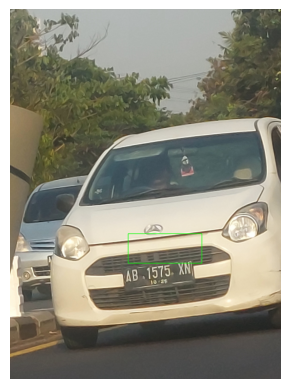

In [66]:
path_test = 'D:\Kuliah\Semester 7\PAI\Deteksi Plat\Data\merge\K3_AB1575XN.jpg'
xmin, xmax, ymin, ymax, image = object_detection(path_test)
plt.figure()
plt.imshow(image)
plt.axis('off')
plt.show()

In [41]:
img = np.array(load_img(path_test))
roi = img[ymin:ymax, xmin:xmax]
result = reader.readtext(roi)
detected_texts = [result[1] for result in result]
print(' '.join(detected_texts[:3]))
plt.imshow(roi)
plt.show()

AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'